## **Import des librairies** 

In [ ]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
import pprint

%matplotlib inline

In [ ]:
tf.random.set_seed(123)
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='imagenet')

vgg.trainable = False
pp.pprint(vgg)

## **Calcul du coût de contenu** 

In [ ]:
def calculer_cout_contenu(contenu_output, generee_output):

  """
  Calculer le coût associé à l'image 'contenu'

  input :
    F_C -- tenseur de dimension (1, n_H, n_W, n_C), représentant les activations de l'image de contenu C
    F_G -- tenseur de dimension (1, n_H, n_W, n_C), représentant les activations du contenu de l'image generée G

  output:
    L_contenu : scalaire
  """

  # récuperer l'activation de la couche 'block5_conv4'
  F_C = contenu_output[-1] 
  F_G = generee_output[-1] 
  
  
  # récuperer les dimensions de F_G
  _, n_H, n_W, n_C = F_G.get_shape().as_list()
  
  # changer les dimensions de a_G et a_C
  F_C_matrice = tf.reshape(F_C, [n_H*n_W, n_C])
  F_G_matrice = tf.reshape(F_G, [n_H*n_W, n_C])
  
  # calculer le coût à l'aide de tensorflow
  L_content = 1/2*tf.reduce_sum(tf.square(tf.subtract(F_C_matrice, F_G_matrice)))

    
  return L_content

## **Calcul du coût de style**

**Calcul de la matrice de gram**



In [ ]:
def matrice_gram(A):
    """
    input:
    A -- une matrice de taille (n_C, n_H*n_W)
    
    output:
    GA -- Matrice de Gram de A, de dimension (n_C, n_C)
    """  

    GA = tf.matmul(A, tf.transpose(A))

    return GA

In [ ]:
def calculer_couche_style_cout(F_S, F_G):
    """
    input:
    F_S -- tenseur de dimension (1, n_H, n_W, n_C), représentant les activations du style de S
    F_G -- tenseur de dimension (1, n_H, n_W, n_C), représentant les activations du style de G
    
    output:
    L_style_layer -- tenseur représentant un scalaire
    """
    
    # récupérer les dimensions de a_G
    _, n_H, n_W, n_C = F_G.get_shape().as_list()
    
    # changer la dimension (n_H * n_W, n_C) pour avoir (n_C, n_H * n_W)
    F_S = tf.transpose(tf.reshape(F_S, [n_H*n_W, n_C]))
    F_G = tf.transpose(tf.reshape(F_G, [n_H*n_W, n_C]))

    # calculer les matrices de Gram
    GS = matrice_gram(F_S)
    GG = matrice_gram(F_G)

    # calculer le coût
    L_style_layer = 1 / (4 * n_C ** 2 * (n_H * n_W) ** 2) * tf.math.reduce_sum(tf.square(tf.subtract(GS, GG)))
    
    
    return L_style_layer

In [ ]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

In [ ]:
def calculer_style_cout(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    calculer le coût de style en pondérant plusieurs couches
    
    input:
    style_image_output -- représentation du l'image style S
    generated_image_output -- représentation du l'image génerée G
    STYLE_LAYERS -- une liste python:
                        - les noms des couches qu'on utilisera pour extraire le style
                        - un coefficient représentant le poids de chaque couche
    
    output: 
    J_style -- un tenseur représentant un scalaire
    """
    
    # initialiser le coût 
    J_style = 0

    # le dernier élément de l'array ne doit pas être utilisé 
    a_S = style_image_output[:-1]

    # le dernier élément de l'array ne doit pas être utilisé 
    a_G = generated_image_output[:-1]

    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):  
        # calculer le cout style de la couche actuelle 
        J_style_layer = calculer_couche_style_cout(a_S[i], a_G[i])

        # pondérer par le poids et ajouter au cout style total
        J_style += weight[1] * J_style_layer

    return J_style

In [ ]:
@tf.function()
def cout_total(L_contenu, L_style, alpha = 10, beta = 40):
    """
    calculer le coût total
    
    input:
    L_contenu -- cout contenu
    L_style -- cout style
    alpha -- hyperparameter représentant l'importance du cout contenu
    beta -- hyperparameter représentant l'importance du cout style
    
    output:
    L -- le cout total
    """

    L = alpha * L_contenu + beta * L_style
    

    return L

In [ ]:
contenu_image = np.array(Image.open("ny.png").resize((img_size, img_size)))
contenu_image = tf.constant(np.reshape(contenu_image, ((1,) + contenu_image.shape)))

print(contenu_image.shape)
imshow(contenu_image[0])
plt.show()

In [ ]:
style_image =  np.array(Image.open("van_gogh.jpg").resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()

In [ ]:
generated_image = tf.Variable(tf.image.convert_image_dtype(contenu_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

In [ ]:
def modele_output(vgg, layer_names):
    """ Créer un modèle VGG qui donne une liste des sorties intermédiares du modèle."""
    
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [ ]:
vgg.summary()

In [ ]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = modele_output(vgg, STYLE_LAYERS + content_layer)

In [ ]:
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(contenu_image, tf.float32))
F_C = vgg_model_outputs(preprocessed_content)

In [ ]:
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
F_S = vgg_model_outputs(preprocessed_style)

In [ ]:
def clip_0_1(image):

    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):

    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # on utilise les représentations calculées précédemment F_S et F_C
        # F_G est calculée comme la sortie de vgg_model_outputs de l'image générée
        

        F_G = vgg_model_outputs(generated_image)
        
        # calculer le cout style

        L_style = calculer_style_cout(F_S, F_G, STYLE_LAYERS=STYLE_LAYERS)


        # calculer le cout contenu
        L_contenu = calculer_cout_contenu(F_C, F_G)


        # calculer le cout total
        L = cout_total(L_contenu, L_style, alpha = 1, beta = 1000)
        
        
    grad = tape.gradient(L, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    return L

Epoch 0 


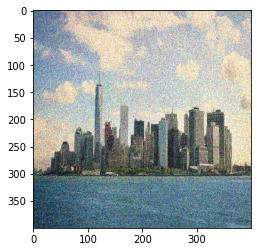

In [ ]:
generated_image = tf.Variable(generated_image)


epochs = 2001

cost = [0]*epochs
for i in range(epochs):
    L = train_step(generated_image)
    cost[i] = L
    if i % 1000 == 0:
      print(f"Epoch {i} ")
    if i % 1000 == 0:
      image = tensor_to_image(generated_image)
      imshow(image)
      image.save(f"image_{i}.jpg")
      plt.show()
    """if cost[i] > cost[i-1]*100:
      print(f"Epoch {i} ")
      image = tensor_to_image(generated_image)
      imshow(image)
      plt.show()
      """

In [ ]:
plt.plot(range(epochs), cost)
plt.ylabel('Le coût total')
plt.xlabel('Epochs')

In [ ]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(contenu_image[0])
ax.title.set_text('Image contenu')
ax = fig.add_subplot(1, 3, 2)
imshow(style_image[0])
ax.title.set_text('Image style')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Image générée')
plt.show()